In [1]:
import sys
import os
from dotenv import load_dotenv

sys.path.append(os.path.abspath('src'))

In [2]:
import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader

mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="SoccerNet")
load_dotenv()
mySoccerNetDownloader.password = os.getenv("SOCCERNET_KEY")

# # Downloading the annotations of the 500 games
# mySoccerNetDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

In [3]:
from utils import Utilities
utilities = Utilities("SoccerNet")

# utilities.save_labels_in_csv()

In [4]:
from data_loading import DataLoading

batch_size = 16
fps = 2
chunk_length = 60

train_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="train")
val_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="valid")

train_loader = train_dataloading.get_dataloader()
val_loader = val_dataloading.get_dataloader()

In [5]:
import torch
from torch.utils.data import DataLoader
import model
import numpy as np

from training import Trainer

model = model.Model(input_dim=512, num_classes=17)


Epoch 1/100: Loss = 0.69, mAP = 0.15
Epoch 2/100: Loss = 0.69, mAP = 0.16
Epoch 3/100: Loss = 0.69, mAP = 0.16
Epoch 4/100: Loss = 0.69, mAP = 0.15
Epoch 5/100: Loss = 0.69, mAP = 0.15
Epoch 6/100: Loss = 0.69, mAP = 0.15
Epoch 7/100: Loss = 0.69, mAP = 0.15
Epoch 8/100: Loss = 0.69, mAP = 0.15
Epoch 9/100: Loss = 0.69, mAP = 0.15
Epoch 10/100: Loss = 0.69, mAP = 0.15
Epoch 11/100: Loss = 0.69, mAP = 0.15
Epoch 12/100: Loss = 0.69, mAP = 0.15
Epoch 13/100: Loss = 0.69, mAP = 0.15
Epoch 14/100: Loss = 0.69, mAP = 0.15
Epoch 15/100: Loss = 0.69, mAP = 0.15
Epoch 16/100: Loss = 0.69, mAP = 0.15
Epoch 17/100: Loss = 0.69, mAP = 0.15
Epoch 18/100: Loss = 0.69, mAP = 0.15
Epoch 19/100: Loss = 0.69, mAP = 0.15
Epoch 20/100: Loss = 0.69, mAP = 0.15
Epoch 21/100: Loss = 0.69, mAP = 0.15
Epoch 22/100: Loss = 0.69, mAP = 0.15
Epoch 23/100: Loss = 0.69, mAP = 0.15
Epoch 24/100: Loss = 0.69, mAP = 0.15
Epoch 25/100: Loss = 0.69, mAP = 0.15
Epoch 26/100: Loss = 0.69, mAP = 0.15
Epoch 27/100: Loss = 

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

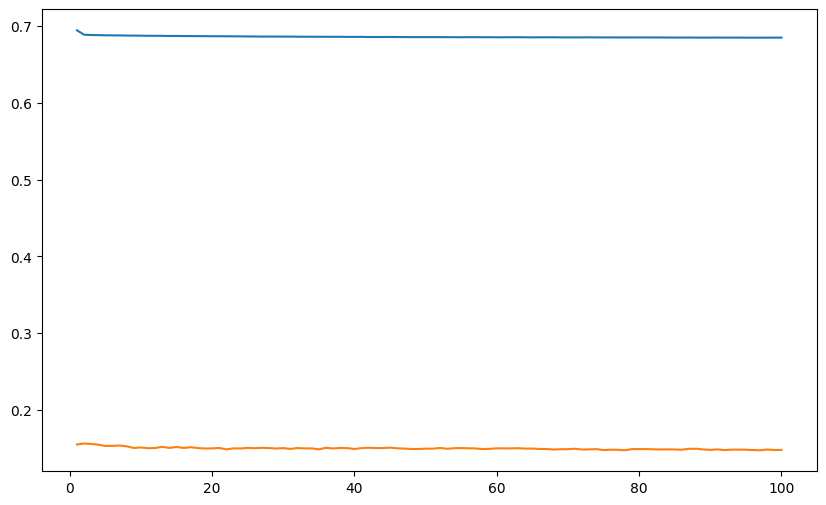

In [ ]:
trainer = Trainer(model, train_loader, val_loader, epochs=100, batch_size=batch_size, prediction_threshold=0.4)

# Train the model
trainer.train()

In [ ]:
# Downloading the videos of the 500 games
mySoccerNetDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley\1_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley\2_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal\1_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal\2_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Swansea 2 - 1 Manchester United\1_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-21 - 18-00 Swansea 2 - 1 Manchester United\2_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-22 - 19-15 Southampton 0 - 2 Liverpool\1_224p.mkv already exists
SoccerNet\england_epl\2014-2015\2015-02-22 - 19-15 Southampton 0 - 2 Liverpool\2_224p.mkv already exists
SoccerNet\england_epl\2015-2016\2015-08-08 - 19-30 Chelsea 2 - 2 Swansea\1_224p.mkv already exists
SoccerNet\england_epl\2015-2016\2015-08-08 - 19-30 Chelsea 2 - 

In [ ]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 20)
pd.set_option('display.colheader_justify', 'center')

annotations_df = utilities.parse_labels_json()
annotations_engineered_df = utilities.parse_labels_json_with_feature_engineering()

display(annotations_df.head())
annotations_df.to_csv("annotations.csv", index=False)

display(annotations_engineered_df.head(100))
annotations_engineered_df.to_csv("annotations_engineered.csv", index=False)

In [ ]:
print("Number of rows:", annotations_engineered_df.shape[0])
print("Number of columns:", annotations_engineered_df.shape[1])

In [ ]:
print("DataFrame Info:")
print(annotations_engineered_df.info())

In [ ]:
print("Missing Values per Column:")
print(annotations_engineered_df.isnull().sum())


In [ ]:
print("Descriptive Statistics (Including Non-Numerical):")
display(annotations_engineered_df.describe(include='all'))

In [ ]:
# Number of unique labels (excluding game-related columns)
label_columns = [col for col in annotations_engineered_df.columns if col.startswith('label_')]
unique_labels = len(label_columns)
print("Number of unique labels:", unique_labels)

# List of unique labels (based on the column names)
print("Unique labels:", label_columns)


In [ ]:
utilities.print_labels_distribution(annotations_engineered_df)

In [ ]:
utilities.print_labels_frequency(annotations_engineered_df)

In [ ]:
utilities.print_labels_frequency_per_league(annotations_engineered_df)

In [ ]:
utilities.print_labels_distribution_over_game_intervals(annotations_engineered_df)